In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas.tseries.offsets import DateOffset

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option('display.max_columns', None)

### Data Import and Prepping

In [3]:
#vehicle revenue miles (VRM)
df = pd.read_excel('May 2023 Complete Monthly Ridership (with adjustments and estimates).xlsx', sheet_name='VRM')

df.head()

,NTD ID,Legacy NTD ID,Agency,Status,Reporter Type,UZA,UACE CD,UZA Name,Mode,TOS,3 Mode,1/2002,2/2002,3/2002,4/2002,5/2002,6/2002,7/2002,8/2002,9/2002,10/2002,11/2002,12/2002,1/2003,2/2003,3/2003,4/2003,5/2003,6/2003,7/2003,8/2003,9/2003,10/2003,11/2003,12/2003,1/2004,2/2004,3/2004,4/2004,5/2004,6/2004,7/2004,8/2004,9/2004,10/2004,11/2004,12/2004,1/2005,2/2005,3/2005,4/2005,5/2005,6/2005,7/2005,8/2005,9/2005,10/2005,11/2005,12/2005,1/2006,2/2006,3/2006,4/2006,5/2006,6/2006,7/2006,8/2006,9/2006,10/2006,11/2006,12/2006,1/2007,2/2007,3/2007,4/2007,5/2007,6/2007,7/2007,8/2007,9/2007,10/2007,11/2007,12/2007,1/2008,2/2008,3/2008,4/2008,5/2008,6/2008,7/2008,8/2008,9/2008,10/2008,11/2008,12/2008,1/2009,2/2009,3/2009,4/2009,5/2009,6/2009,7/2009,8/2009,9/2009,10/2009,11/2009,12/2009,1/2010,2/2010,3/2010,4/2010,5/2010,6/2010,7/2010,8/2010,9/2010,10/2010,11/2010,12/2010,1/2011,2/2011,3/2011,4/2011,5/2011,6/2011,7/2011,8/2011,9/2011,10/2011,11/2011,12/2011,1/2012,2/2012,3/2012,4/2012,5/2012,6/2012,7/2012,8/2012,9/2012,10/2012,11/2012,12/2012,1/2013,2/2013,3/2013,4/2013,5/2013,6/2013,7/2013,8/2013,9/2013,10/2013,11/2013,12/2013,1/2014,2/2014,3/2014,4/2014,5/2014,6/2014,7/2014,8/2014,9/2014,10/2014,11/2014,12/2014,1/2015,2/2015,3/2015,4/2015,5/2015,6/2015,7/2015,8/2015,9/2015,10/2015,11/2015,12/2015,1/2016,2/2016,3/2016,4/2016,5/2016,6/2016,7/2016,8/2016,9/2016,10/2016,11/2016,12/2016,1/2017,2/2017,3/2017,4/2017,5/2017,6/2017,7/2017,8/2017,9/2017,10/2017,11/2017,12/2017,1/2018,2/2018,3/2018,4/2018,5/2018,6/2018,7/2018,8/2018,9/2018,10/2018,11/2018,12/2018,1/2019,2/2019,3/2019,4/2019,5/2019,6/2019,7/2019,8/2019,9/2019,10/2019,11/2019,12/2019,1/2020,2/2020,3/2020,4/2020,5/2020,6/2020,7/2020,8/2020,9/2020,10/2020,11/2020,12/2020,1/2021,2/2021,3/2021,4/2021,5/2021,6/2021,7/2021,8/2021,9/2021,10/2021,11/2021,12/2021,1/2022,2/2022,3/2022,4/2022,5/2022,6/2022,7/2022,8/2022,9/2022,10/2022,11/2022,12/2022,1/2023,2/2023,3/2023,4/2023,5/2023
0,1.0,0001,King County Department of Metro Transit,Active,Full Reporter: Operating,14.0,80389.0,"Seattle--Tacoma, WA",DR,PT,Bus,746158.0,656324.0,726578.0,736975.0,746158.0,696633.0,746158.0,747339.0,695451.0,766920.0,696633.0,725396.0,761210.0,697454.0,777948.0,795216.0,787912.0,748855.0,793074.0,754939.0,752394.0,843825.0,701931.0,728026.0,747628.0,771845.0,883913.0,857232.0,841169.0,847193.0,825119.0,820359.0,806457.0,829771.0,895134.0,905623.0,774351.0,753949.0,848372.0,821603.0,886438.0,862034.0,843133.0,905209.0,845207.0,865101.0,812467.0,797799.0,798647.0,754978.0,870726.0,811068.0,869933.0,862697.0,864720.0,940351.0,882333.0,895883.0,765935.0,728139.0,789831.0,782401.0,872267.0,864049.0,963309.0,846949.0,848425.0,891059.0,799670.0,921386.0,829419.0,820341.0,746766.0,735504.0,760462.0,797155.0,794368.0,749376.0,793643.0,750790.0,745579.0,848123.0,714143.0,737948.0,841743.0,774171.0,853798.0,851673.0,816168.0,828250.0,855102.0,832296.0,832413.0,897303.0,782787.0,809271.0,778833.0,753302.0,867834.0,836731.0,808656.0,810494.0,812026.0,824703.0,816410.0,878178.0,763045.0,816721.0,835425.0,780800.0,922064.0,863560.0,877355.0,858632.0,807759.0,866152.0,821033.0,849680.0,800887.0,752367.0,708973.0,814776.0,867424.0,833241.0,882908.0,809746.0,812980.0,851610.0,767559.0,873579.0,794750.0,741422.0,823920.0,778181.0,832695.0,854336.0,872258.0,788483.0,825955.0,819781.0,760267.0,862747.0,745981.0,705354.0,768910.0,688770.0,748916.0,781409.0,761544.0,714233.0,726415.0,702592.0,693406.0,776224.0,654371.0,658414.0,585118.0,558914.0,599948.0,587702.0,574770.0,569771.0,562844.0,547513.0,528987.0,571210.0,502916.0,515948.0,628731.0,657129.0,706423.0,686973.0,681681.0,668495.0,633077.0,695930.0,655110.0,681981.0,641698.0,596968.0,635089.0,578776.0,701185.0,657496.0,693832.0,662008.0,632230.0,682834.0,613870.0,689045.0,644004.0,611734.0,695625.0,634643.0,707393.0,699070.0,735695.0,686858.0,696654.0,734015.0,649497.0,753757.0,686471.0,656197.0,722368.0,503211.0,718918.0,741892.0,760626.0,702880.0,749261.0,751070.0,702267.0,789753

In [4]:
col = df.columns.to_list()
print(col)

['NTD ID', 'Legacy NTD ID', 'Agency', 'Status', 'Reporter Type', 'UZA', 'UACE CD', 'UZA Name', 'Mode', 'TOS', '3 Mode', '1/2002', '2/2002', '3/2002', '4/2002', '5/2002', '6/2002', '7/2002', '8/2002', '9/2002', '10/2002', '11/2002', '12/2002', '1/2003', '2/2003', '3/2003', '4/2003', '5/2003', '6/2003', '7/2003', '8/2003', '9/2003', '10/2003', '11/2003', '12/2003', '1/2004', '2/2004', '3/2004', '4/2004', '5/2004', '6/2004', '7/2004', '8/2004', '9/2004', '10/2004', '11/2004', '12/2004', '1/2005', '2/2005', '3/2005', '4/2005', '5/2005', '6/2005', '7/2005', '8/2005', '9/2005', '10/2005', '11/2005', '12/2005', '1/2006', '2/2006', '3/2006', '4/2006', '5/2006', '6/2006', '7/2006', '8/2006', '9/2006', '10/2006', '11/2006', '12/2006', '1/2007', '2/2007', '3/2007', '4/2007', '5/2007', '6/2007', '7/2007', '8/2007', '9/2007', '10/2007', '11/2007', '12/2007', '1/2008', '2/2008', '3/2008', '4/2008', '5/2008', '6/2008', '7/2008', '8/2008', '9/2008', '10/2008', '11/2008', '12/2008', '1/2009', '2/2009',

In [5]:
id_list = col[:11]
value_list = col[11:]
print(value_list)

['1/2002', '2/2002', '3/2002', '4/2002', '5/2002', '6/2002', '7/2002', '8/2002', '9/2002', '10/2002', '11/2002', '12/2002', '1/2003', '2/2003', '3/2003', '4/2003', '5/2003', '6/2003', '7/2003', '8/2003', '9/2003', '10/2003', '11/2003', '12/2003', '1/2004', '2/2004', '3/2004', '4/2004', '5/2004', '6/2004', '7/2004', '8/2004', '9/2004', '10/2004', '11/2004', '12/2004', '1/2005', '2/2005', '3/2005', '4/2005', '5/2005', '6/2005', '7/2005', '8/2005', '9/2005', '10/2005', '11/2005', '12/2005', '1/2006', '2/2006', '3/2006', '4/2006', '5/2006', '6/2006', '7/2006', '8/2006', '9/2006', '10/2006', '11/2006', '12/2006', '1/2007', '2/2007', '3/2007', '4/2007', '5/2007', '6/2007', '7/2007', '8/2007', '9/2007', '10/2007', '11/2007', '12/2007', '1/2008', '2/2008', '3/2008', '4/2008', '5/2008', '6/2008', '7/2008', '8/2008', '9/2008', '10/2008', '11/2008', '12/2008', '1/2009', '2/2009', '3/2009', '4/2009', '5/2009', '6/2009', '7/2009', '8/2009', '9/2009', '10/2009', '11/2009', '12/2009', '1/2010', '2/20

In [6]:
data = (df.melt(id_vars=id_list,
                value_vars =value_list,var_name ='Date',value_name="Total")
 .replace('', np.nan,)
 .dropna()
)

data.head()

,NTD ID,Legacy NTD ID,Agency,Status,Reporter Type,UZA,UACE CD,UZA Name,Mode,TOS,3 Mode,Date,Total
0,1.0,0001,King County Department of Metro Transit,Active,Full Reporter: Operating,14.0,80389.0,"Seattle--Tacoma, WA",DR,PT,Bus,1/2002,746158.0
1,1.0,0001,King County Department of Metro Transit,Active,Full Reporter: Operating,14.0,80389.0,"Seattle--Tacoma, WA",DR,TN,Bus,1/2002,0.0
2,1.0,0001,King County Department of Metro Transit,Active,Full Reporter: Operating,14.0,80389.0,"Seattle--Tacoma, WA",DR,TX,Bus,1/2002,0.0
3,1.0,0001,King County Department of Metro Transit,Active,Full Reporter: Operating,14.0,80389.0,"Seattle--Tacoma, WA",FB,DO,Ferry,1/2002,0.0
4,1.0,0001,King County Department of Metro Transit,Active,Full Reporter: Operating,14.0,80389.0,"Seattle--Tacoma, WA",LR,DO,Rail,1/2002,2655.0


In [7]:
# foothill_transit = data.loc[data['Agency'] == 'Foothill Transit']
# foothill_transit['Date'] = pd.to_datetime(foothill_transit['Date'], format='%m/%Y')

In [8]:
# df2 = foothill_transit[['Date','Total']].copy().reset_index(drop=True)
# df2.set_index('Date', inplace=True)
# df2.head()

In [9]:
metro_lr = data.loc[(data['Agency'] == 'Los Angeles County Metropolitan Transportation Authority ')&(data['Mode']=='LR')]
metro_lr['Date'] = pd.to_datetime(metro_lr['Date'], format='%m/%Y')

C:\Users\cindy\AppData\Local\Temp\ipykernel_29448\2055725215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metro_lr['Date'] = pd.to_datetime(metro_lr['Date'], format='%m/%Y')


In [10]:
df2 = metro_lr[['Date','Total']].copy().reset_index(drop=True)
df2.set_index('Date', inplace=True)
df2.head()

,Total
Date,
2002-01-01,483718.0
2002-02-01,457688.0
2002-03-01,543135.0
2002-04-01,545845.0
2002-05-01,587328.0


In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    return df

In [12]:
df2 = create_features(df2)
df2.head()

,Total,year,month,quarter
Date,,,,
2002-01-01,483718.0,2002,1,1
2002-02-01,457688.0,2002,2,1
2002-03-01,543135.0,2002,3,1
2002-04-01,545845.0,2002,4,2
2002-05-01,587328.0,2002,5,2


In [13]:
tss = TimeSeriesSplit(n_splits=5,test_size=12,gap=0)
df2 = df2.sort_index()

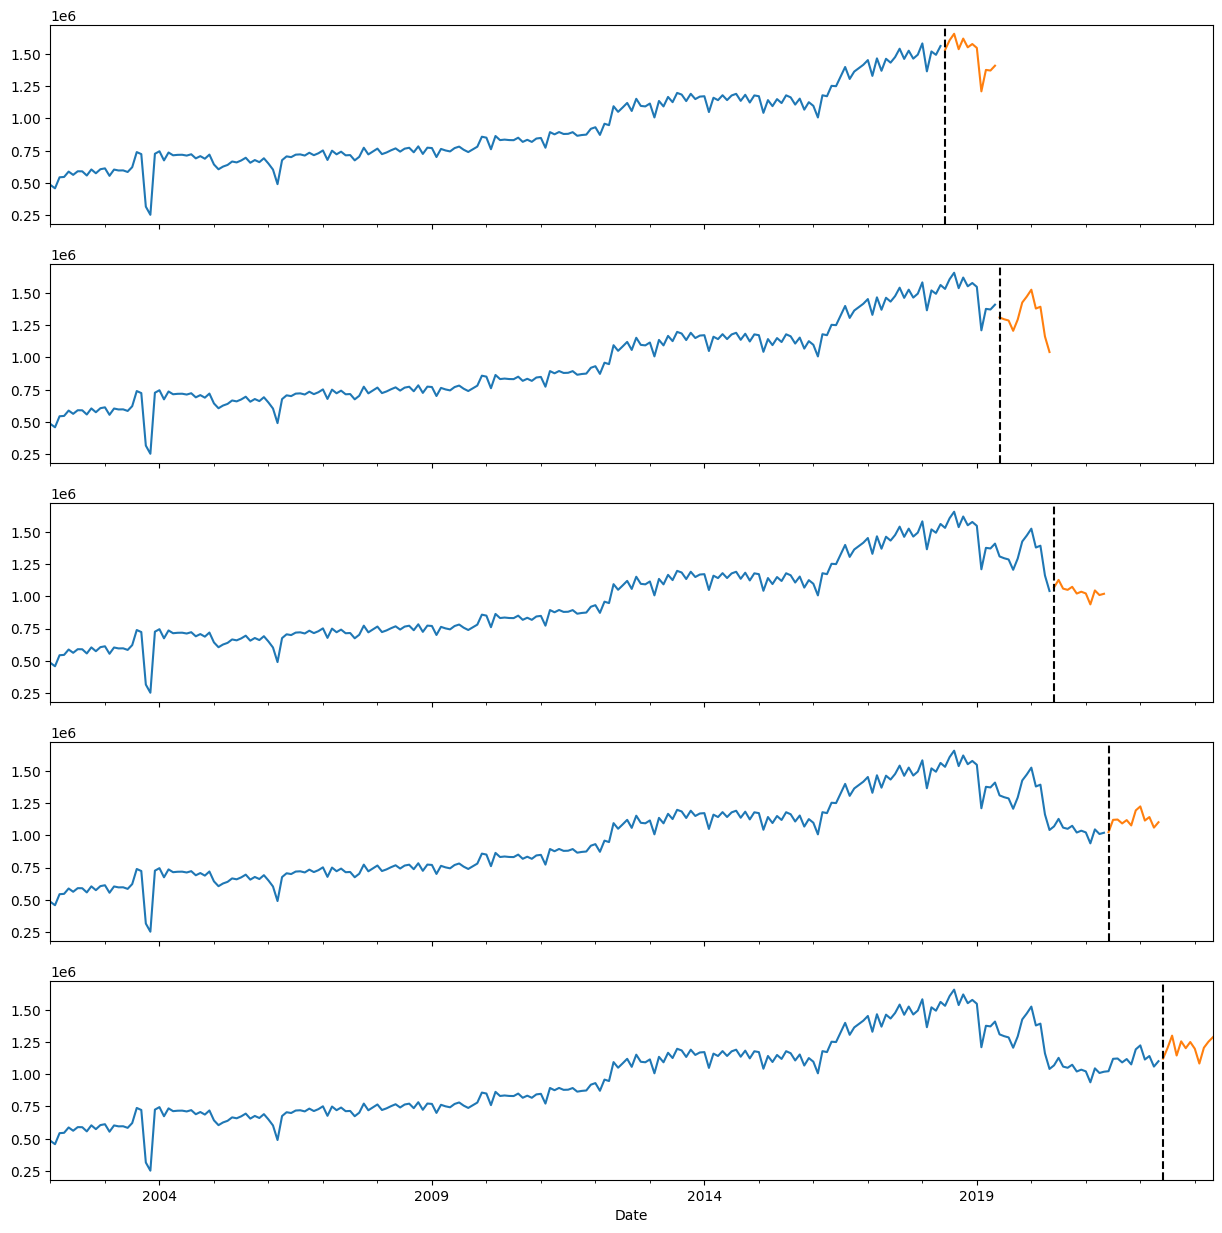

In [14]:
fig, axs = plt.subplots(5,1,figsize=(15,15),sharex=True)
fold=0
for train_idx, val_idx in tss.split(df2):
    train = df2.iloc[train_idx]
    test = df2.iloc[val_idx]
    train['Total'].plot(ax=axs[fold],label='Training Set')
    test['Total'].plot(ax=axs[fold],label='Test Set')
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    fold += 1

In [15]:
def add_lags(df):
    target_map = df2['Total'].to_dict()
    df2['lag1']=(df2.index - DateOffset(months=12)).map(target_map)
    df2['lag2']=(df2.index - DateOffset(months=24)).map(target_map)
    return df

In [16]:
df2 = add_lags(df2)

In [17]:
df2.tail()

,Total,year,month,quarter,lag1,lag2
Date,,,,,,
2023-01-01,1197372.0,2023,1,1,1223276.0,1021909.0
2023-02-01,1082584.0,2023,2,1,1113761.0,937085.0
2023-03-01,1204883.0,2023,3,1,1140831.0,1045260.0
2023-04-01,1251593.0,2023,4,2,1059142.0,1009520.0
2023-05-01,1287033.0,2023,5,2,1100820.0,1019234.0


In [18]:
FEATURES = ['year', 'month','quarter', 'lag1', 'lag2']
TARGET = 'Total'

In [19]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df2):
    train = df2.iloc[train_idx]
    test = df2.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[15:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:941999.94405	validation_1-rmse:1491346.18019
[100]	validation_0-rmse:359886.12795	validation_1-rmse:633913.36736


[200]	validation_0-rmse:145673.24842	validation_1-rmse:286435.81717
[300]	validation_0-rmse:72063.83621	validation_1-rmse:156038.75761
[400]	validation_0-rmse:49429.20550	validation_1-rmse:123831.13103
[500]	validation_0-rmse:41709.28072	validation_1-rmse:119513.20924
[600]	validation_0-rmse:36894.09144	validation_1-rmse:118434.27193
[620]	validation_0-rmse:35897.42294	validation_1-rmse:118589.46938
[15:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:981670.84021	validation_1-rmse:1307379.34280
[100]	validation_0-rmse:374087.12824	validation_1-rmse:419441.60600
[200]	validation_0-rmse:150987.41638	validation_1-rmse:157101.54372
[300]	validation_0-rmse:73410.81775	validation_1-rmse:143632.43325
[312]	validation_0-rmse:68861.59709	validation_1-rmse:145717.69829
[15:30:06] WARNING: C:\buildk

In [20]:
scores

[118137.1069843269,
 139789.5113562346,
 46659.30505866211,
 103741.58939367619,
 161268.13723208007]

In [21]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,columns=['importance'])
fi

,importance
year,0.090324
month,0.015391
quarter,0.000000
lag1,0.629127
lag2,0.265157


In [22]:
preds

[array([1514138.8, 1520126.1, 1523384.8, 1535357.6, 1498437.8, 1508859.1,
        1496886.2, 1509437.9, 1475550.8, 1507564.2, 1507564.2, 1516592.4],
       dtype=float32),
 array([1358166.1, 1325748.2, 1325748.2, 1331412.5, 1325748.2, 1331412.5,
        1325748.2, 1300323.4, 1190653. , 1282142.4, 1282142.4, 1307465.6],
       dtype=float32),
 array([1039360.75, 1039360.75, 1039360.75, 1039360.75, 1039360.75,
        1048874.9 , 1048874.9 , 1048874.9 , 1039360.75, 1039360.75,
        1039360.75,  965120.4 ], dtype=float32),
 array([1032696.44, 1035064.2 , 1014767.1 , 1016573.7 , 1038884.4 ,
        1011426.4 , 1013502.75, 1055316.9 , 1025111.6 , 1018467.4 ,
         982076.06, 1025998.06], dtype=float32),
 array([1085835.9, 1060484.9, 1060309.6, 1059750.5, 1059750.5, 1058053.9,
        1074091.9, 1100669.9, 1055506.6, 1068985.9, 1038371. , 1035930.8],
       dtype=float32)]

In [23]:
test['prediction'] = reg.predict(X_test)
df2 = df2.merge(test[['prediction']], how='left',left_index=True, right_index=True)

C:\Users\cindy\AppData\Local\Temp\ipykernel_29448\2228199816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


In [24]:
df2

,Total,year,month,quarter,lag1,lag2,prediction
Date,,,,,,,
2002-01-01,483718.0,2002,1,1,NaN,NaN,NaN
2002-02-01,457688.0,2002,2,1,NaN,NaN,NaN
2002-03-01,543135.0,2002,3,1,NaN,NaN,NaN
2002-04-01,545845.0,2002,4,2,NaN,NaN,NaN
2002-05-01,587328.0,2002,5,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-01-01,1197372.0,2023,1,1,1223276.0,1021909.0,1.100670e+06
2023-02-01,1082584.0,2023,2,1,1113761.0,937085.0,1.055507e+06
2023-03-01,1204883.0,2023,3,1,1140831.0,1045260.0,1.068986e+06


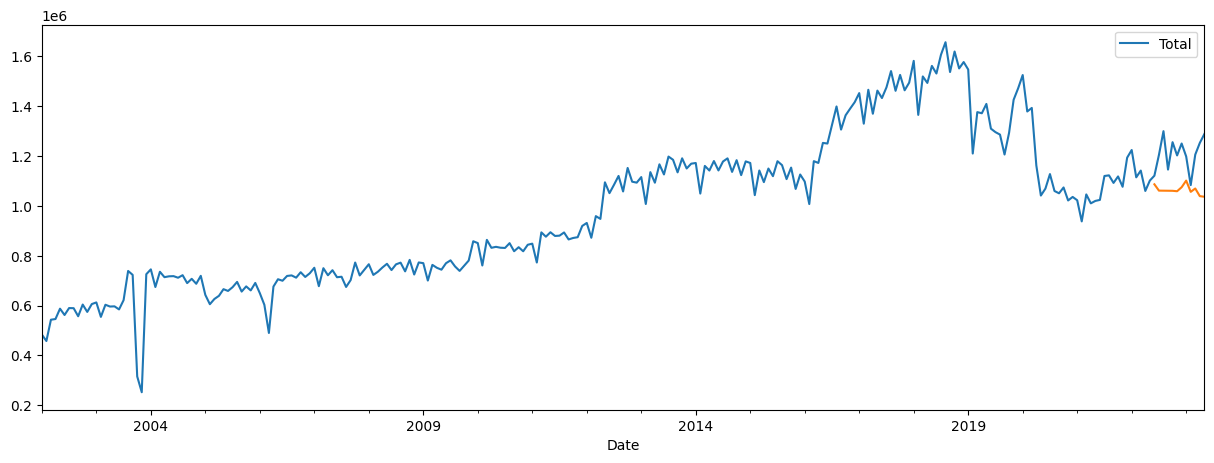

In [25]:
ax = df2[['Total']].plot(figsize=(15,5))
df2['prediction'].plot(ax=ax)
plt.show()

In [26]:
t = np.arange(np.datetime64("2023-06-01"), np.datetime64("2024-06-01"),  np.timedelta64(1, 'M'),  dtype='datetime64[M]')  

future_df = pd.DataFrame(index=t)
future_df['isFuture'] = True
df2['isFuture'] = False
df_and_future = pd.concat([df2, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

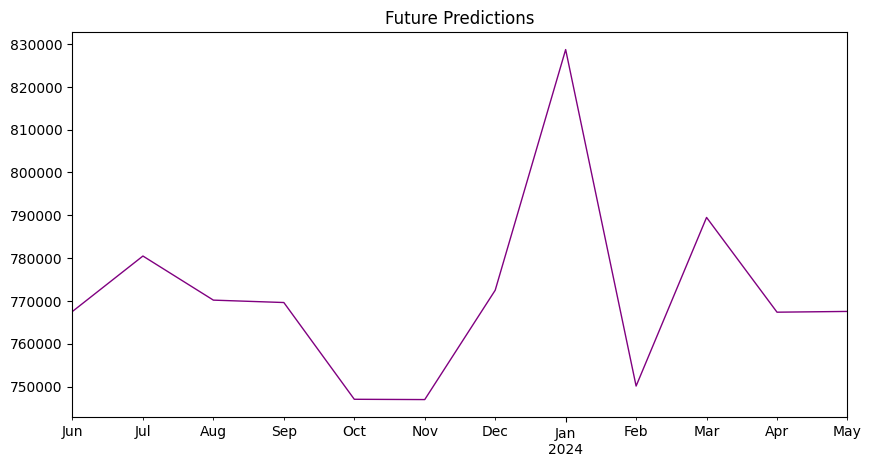

In [27]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color='purple',
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

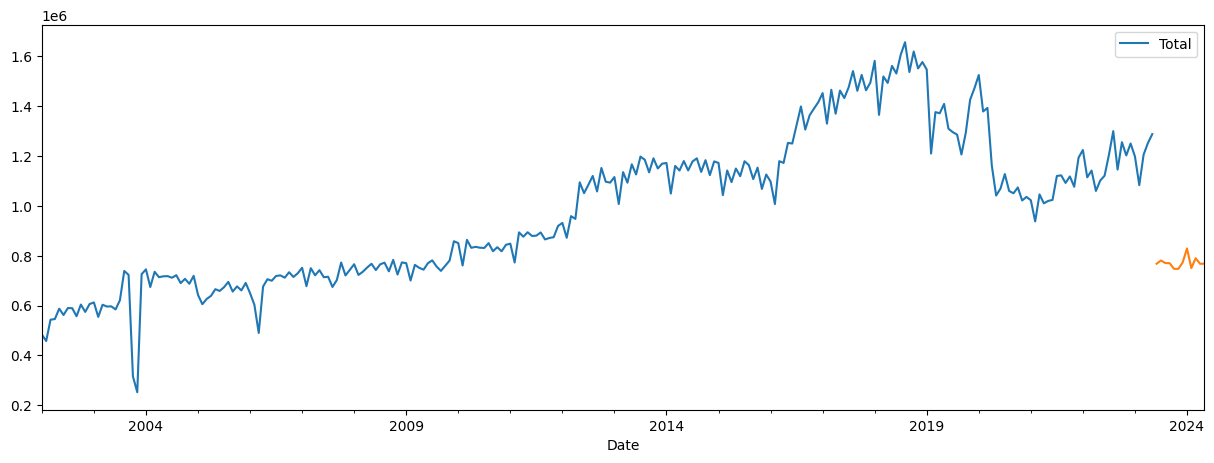

In [28]:
ax = df2[['Total']].plot(figsize=(15,5))
future_w_features['pred'].plot(ax=ax)
plt.show()

In [29]:
future_w_features

,Total,year,month,quarter,lag1,lag2,prediction,isFuture,pred
2023-06-01,NaN,2023,6,2,NaN,NaN,NaN,True,767545.3750
2023-07-01,NaN,2023,7,3,NaN,NaN,NaN,True,780483.3125
2023-08-01,NaN,2023,8,3,NaN,NaN,NaN,True,770184.5625
2023-09-01,NaN,2023,9,3,NaN,NaN,NaN,True,769625.3750
2023-10-01,NaN,2023,10,4,NaN,NaN,NaN,True,747031.1875
2023-11-01,NaN,2023,11,4,NaN,NaN,NaN,True,746961.2500
2023-12-01,NaN,2023,12,4,NaN,NaN,NaN,True,772496.1875
2024-01-01,NaN,2024,1,1,NaN,NaN,NaN,True,828695.1250
2024-02-01,NaN,2024,2,1,NaN,NaN,NaN,True,750120.6875
2024-03-01,NaN,2024,3,1,NaN,NaN,NaN,True,789496.5000
